In [5]:
import MDAnalysis as md # distances in Angstroem
from MDAnalysis.lib.pkdtree import PeriodicKDTree
from MDAnalysis.lib.distances import distance_array
from MDAnalysis.analysis.dihedrals import Ramachandran
from MDAnalysis.analysis.hbonds.hbond_analysis import HydrogenBondAnalysis as HBA
from sklearn.cluster import KMeans
import mdtraj # necessary for dssp
import networkx as nx
import numpy as np
import h5py as h5
import warnings

In [61]:
class TransitionNetworks:
    topology = None
    trajectory = None
    state = []
    nLigandChains = 0  
    nProteinChains = 0

    
    
    """The descriptors and corresponding cutoffs to use for constructing the transition matrix."""
    descriptors = {}
    
    def __init__(self, top=topology, traj=trajectory, nLigandChains=nLigandChains,\
                 nProteinChains=nProteinChains,desc=descriptors, state=state,\
                 h5File='transitionNetwork.hdf5'):
        
        self.top = top
        self.traj = traj
        self.universe = md.Universe(top, traj)
        
        self.nLigandChains = nLigandChains
        self.nAtomsPerLigandChain = int(len(self.universe.select_atoms("resname LIG"))/nLigandChains)
        self.nResiduesPerLigandChain = int(len(self.universe.select_atoms("resname LIG").residues)/nLigandChains)

        self.nProteinChains = nProteinChains
        self.nAtomsPerProteinChain = int(len(self.universe.select_atoms("protein"))/nProteinChains)
        self.nResiduesProteinPerChain = int(len(self.universe.select_atoms("protein").residues)/nProteinChains)

        self.nFrames = self.universe.trajectory.n_frames
        self.state = state
        self.h5File = h5File
        
        """Sort the descriptors dictionary by cutoffs in decreasing order."""
        self.descriptors = {k: v for k, v in sorted(desc.items(), key=lambda item: -item[1])}

        """Generate array with cutoff values in decreasing order."""
        self.cutoffs = np.unique(list(self.descriptors.values()))[::-1]
        
        """Generate array to connect atom indices with residue names."""
        self.resnames = self.universe.atoms.resnames
        
        """Generate array to connect atom indices with residue indices."""
        self.resindices = self.universe.atoms.resindices    
    
    def _intermolecularContactPairs(self):
        """The largest cutoff value 'cutoff0' defines the search distance for the k-d tree."""
        cutoff0 = self.cutoffs[0]
        
        """All other cutoffs are stored in the array cutoffs1"""
        cutoffs1 = self.cutoffs[1:]

        with h5.File(self.h5File, 'a') as f:
            """Create/Check if group 'contactPairs' is present in the file. Structure
            of this group is: (nFrames, nCutoffs, contactPairs[cutoff])."""
            group = f.require_group(name='contactPairs')
            
            for frameIdx, frame in enumerate(self.universe.trajectory):
                frameIdx = str(frameIdx)
                
                """Extract the unit cell information 'box' and the concatenated positions
                'pos Concatenated' for every frame."""
                box = frame.dimensions
                posConcatenated = frame.positions
                
                """Initialize the periodic k-d tree 'tree' with the unit cell information.
                From MD analysis online documentation:
                Number of entries in leafs of the KDTree. If you suffer poor performance 
                you can play around with this number. Increasing the leafsize will speed
                up the construction of the KDTree but slow down the search."""
                tree = PeriodicKDTree(box=box, leafsize=5)
                
                """Reshape the positions array from shape (nAtomsPerChain*nChains, 3) to
                (nChains, nAtomsPerChain, 3) 'pos' seperately for protein and ligand."""
                
                posProtein = np.split(posConcatenated[:self.nProteinChains*self.nAtomsPerProteinChain], self.nProteinChains)
                posLigand = np.split(posConcatenated[self.nProteinChains*self.nAtomsPerProteinChain:-1], self.nLigandChains)

                """Build the k-d tree using the coordinates of one chain and then search
                all intermolecular contacts using the coordinates of the remaining chains."""
                contactPairs = list([] for d in self.cutoffs)

                for excludeChain in range(self.nProteinChains):
                    
                    """Extract the coordinates of one protein chain."""
                    excludePos = posProtein[excludeChain]

                    """Build the k-d tree using these coordinates. From MD analysis online
                    documentation: 'cutoff': Specified cutoff distance to create duplicate images.
                    Typically equivalent to the desired search radius or the maximum of the 
                    desired cutoff radius."""
                    tree.set_coords(excludePos, cutoff=cutoff0)

                    """Extract all intermolecular contact pairs within the cutoff0 and correct atom
                    indicies."""
                    for ligandChainIdx, includePos in enumerate(posLigand):
                        for pair in tree.search_tree(includePos, cutoff0):                                        
                                                        
                            atomIdxLigand = pair[0]                            
                            atomIdxProtein = pair[1]
    
                            """Compute the exact distance of this intermolecular distance pair using pbc."""
                            distance = distance_array(posLigand[ligandChainIdx][atomIdxLigand],
                                                      posProtein[excludeChain][atomIdxProtein],
                                                      box=box)[0][0]

                            """Compare the calculated distance with the given cutoffs, stop if cutoff is
                            greater than the given value. 'depth' allows to return the 'stop cutoff' value
                            by self.cutoffs[depth]."""
                            depth = 0
                            for cValue in cutoffs1:
                                if (distance < cValue):
                                    depth += 1
                                else:
                                    break
                                    
                            globalAtomIdxLigand = pair[0] + self.nAtomsPerLigandChain*ligandChainIdx + self.nAtomsPerProteinChain*self.nProteinChains
                            globalAtomIdxProtein = pair[1] + self.nAtomsPerProteinChain*excludeChain
                                                       
                            """Append the contact pair to the last undercut cutoff value array."""
                            contactPairs[depth].append(sorted([globalAtomIdxProtein, globalAtomIdxLigand]))
                            

                    """Store the intermolecular contact pairs array in the hdf5 file."""
                    subGroup = group.require_group(name=frameIdx)
                    for depth, data in enumerate(contactPairs):
                        subGroup.create_dataset(name=str(self.cutoffs[depth]), data=data)
    
    
    def _residuesWithAttribute(self, descriptorName=None, attribute=None):
        """The user can define an attribute group by augmentation or modification of
        the 'attributes' dictionary."""
        attributes = {'hydrophobic': ['GLY', 'ALA', 'VAL', 'LEU', 'ILE', 'PRO', 'PHE', 'MET', 'TRP'],
                      'polar': ['SER', 'THR', 'CYS', 'ASN', 'GLN', 'TYR'],
                      'charged':['ARG','HIS', 'LYS','ASP', 'GLU']}
        residuesWithAttribute = attributes[attribute]
    
    
        """Get the cutoff value for the descriptor function."""
        cutoff = self.descriptors[descriptorName]
        
        """Open the hdf5 file and create the group 'descriptorName' to store all information
        for this descriptor function. The structure of this group is (nFrames, nChains, any)."""
        with h5.File(self.h5File, 'a') as f:
            group = f.require_group(name=descriptorName+str(cutoff))

            """Extract the contact pairs for every frame for the descriptor."""
            for frameIdx in f['contactPairs']:
                frameIdx = str(frameIdx)
                contactPairs = list(f['contactPairs'][frameIdx][str(cutoff)])
                

                """Array to be filled with information to identify which residues are in contact 
                within the cutoff value distance. Set is chosen because it has the helpful add
                feature, means that if the chain index is already included it is not appended
                multiple times, which would be the case when appending to a list."""
                residuesInContact = []

                """Get the residue names of the atom indices and see if they belong to the
                chosen attribute."""
                for atomIdxChainA, atomIdxChainB in contactPairs:
                    residueNameA = self.resnames[atomIdxChainA]
                    residueNameB = self.resnames[atomIdxChainB]

                    if (residueNameA in residuesWithAttribute):
                        if (residueNameB in residuesWithAttribute):
                            """Build the 'residuePair' and check if contact between both residues
                            has already been recognized. If not, add it to the array 'residuesInContact'
                            and increase the counter 'resiudesInContactCounter'."""
                            residueIdxA=self.resindices[atomIdxChainA]
                            residueIdxB=self.resindices[atomIdxChainB]
                            residuePair = [residueIdxA, residueIdxB]
                            if residuePair not in residuesInContact:
                                residuesInContact.append(residuePair)
                      
                """Export the data in the hdf5 file."""
                group.create_dataset(name=frameIdx, data=np.array([len(residuesInContact)]))
                
    
    def _hydrophobicContacts(self):
        self._residuesWithAttribute(descriptorName='hydrophobicContacts', attribute='hydrophobic')
    
    def _polarContacts(self):
        self._residuesWithAttribute(descriptorName='polarContacts', attribute='polar')
    
    def _chargedContacts(self):
        self._residuesWithAttribute(descriptorName='chargedContacts', attribute='charged')
                        
    def _hbondContacts(self):        
        
        hbonds = HBA(universe=self.universe)
        hbonds.run()
        
        names = [atom.name for atom in self.universe.atoms]
        protein = [[], []]
        ligand = [[], []]

        for idx, name in enumerate(names):
            if name in hbonds.donors:
                if idx < self.nProteinChains*self.nAtomsPerProteinChain:
                    protein[0].append(idx)
                else:
                    ligand[0].append(idx)

            elif name in hbonds.acceptors:
                if idx < self.nProteinChains*self.nAtomsPerProteinChain:
                    protein[1].append(idx)
                else:
                    ligand[1].append(idx)

        hbondAcceptorsProtein = np.array(protein[1])
        hbondDonorsProtein = np.array(protein[0])
        hbondAcceptorsLigand = np.array(ligand[1])
        hbondDonorsLigand = np.array(ligand[0])

        possibleIntermolecularHbondPairs = []
        for proteinDonor in hbondDonorsProtein:
            for ligandAcceptor in hbondAcceptorsLigand:
                possibleIntermolecularHbondPairs.append([proteinDonor, ligandAcceptor])
        
        for proteinAcceptor in hbondAcceptorsProtein:
            for ligandDonor in hbondDonorsLigand:
                possibleIntermolecularHbondPairs.append([ligandDonor, proteinAcceptor])

        nDifferentHbondPairs = len(possibleIntermolecularHbondPairs)        
        
        descriptorName='hbondContacts'
        
        """Get the cutoff value for the descriptor function HbondContacts."""
        cutoff = self.descriptors[descriptorName]

        """Open the hdf5 file and create the group 'desc' to store all information
        for this descriptor function. The structure of this group is (nFrames, nChains)."""
        with h5.File(self.h5File, 'a') as f:
            group = f.require_group(name=descriptorName+str(cutoff))

            """Extract the contact pairs for every frame for the descriptor."""
            for frameIdx in range(self.nFrames):
                hbondContacts = 0
                frameIdx = str(frameIdx)
                contactPairs = list(f['contactPairs'][frameIdx][str(cutoff)])
        
                for contactPair in contactPairs:
                    for pair in possibleIntermolecularHbondPairs:
                        if np.allclose(pair, np.sort(list(contactPair))):
                            hbondContacts += 1
                            #print(frameIdx+1, pair)

                """Export the data in the hdf5 file."""
                group.create_dataset(name=frameIdx, data=np.array([hbondContacts]))
                
    def _aromaticStacking(self):
        aromatics = {'TYR': ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ'],
             'PHE': ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ'],
             'TRP': ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CE3', 'CZ2', 'CZ3', 'NE1']
            }
        
        weights_dict = {'TYR': np.array([12.011, 12.011, 12.011, 12.011, 12.011, 12.011]),
                   'PHE': np.array([12.011, 12.011, 12.011, 12.011, 12.011, 12.011]),
                   'TRP': np.array([12.011, 12.011, 12.011, 12.011, 12.011, 12.011, 
                                    12.011, 12.011, 14.007])}

        ligand_weights = np.array([12.011, 12.011, 12.011, 12.011,
                                   12.011, 12.011, 12.011, 12.011,
                                   14.007, 12.011]) 

        
        proteinAromaticCindex = []
        ring = []
        ks = []

        count = 0
        for residueName in aromatics.keys():
            atomNames = aromatics[residueName]
            for atom in self.universe.atoms: 
                if atom.resname == residueName:
                    if atom.name in atomNames:
                        if count < len(atomNames)-1:
                            ring.append(atom.index)
                            count +=1
                        else:
                            ring.append(atom.index)
                            proteinAromaticCindex.append(ring)
                            ks.append(atom.resname)
                            
                            ring = []
                            count = 0
                            
        descriptorName='aromaticStacking'
        
        """Get the cutoff value for the descriptor function aromaticStacking."""
        cutoff = self.descriptors[descriptorName]

        """Open the hdf5 file and create the group 'desc' to store all information
        for this descriptor function. The structure of this group is (nFrames, nChains)."""
        with h5.File(self.h5File, 'a') as f:
            group = f.require_group(name=descriptorName+str(cutoff))

            """Extract the contact pairs for every frame for the descriptor."""
            for frameIdx, frame in enumerate(self.universe.trajectory):
                frameIdx = str(frameIdx)

                """Extract the unit cell information 'box' and the concatenated positions
                'pos Concatenated' for every frame."""
                box = frame.dimensions
                posConcatenated = frame.positions
                
                """Enter the index of aromatic ring of the ligand"""
                ligandAromaticC = posConcatenated[304:314]
                ligandAromaticCOM = np.average(ligandAromaticC, weights=ligand_weights, axis=0)


                numberOfContacts = 0
                for key, aromaticCarbons in zip(ks, proteinAromaticCindex):
                    ligandAromaticCOM = np.average(ligandAromaticC, weights=ligand_weights, axis=0)
                    proteinRing = posConcatenated[min(aromaticCarbons):max(aromaticCarbons)+1]
                    proteinAromaticCOM = np.average(proteinRing, weights=weights_dict[key], axis=0)
                    distance = distance_array(ligandAromaticCOM, proteinAromaticCOM,
                                              box=box)[0][0]

                    if distance <= cutoff:
                        numberOfContacts += 1

                """Export the data in the hdf5 file."""
                group.create_dataset(name=frameIdx, data=np.array([numberOfContacts]))

    def _generateTransitionMatrix(self):
        """Generate the key names for the state defining functions, which may either be composed
        of the descriptors name or of the descriptors name and the associated cutoff value."""
        descriptorKeys = []
        for descriptorName in self.state:
            try:
                descriptorKeys.append(descriptorName + str(self.descriptors[descriptorName]))
            except KeyError:
                descriptorKeys.append(descriptorName)
        
        differentStatesList = []
        populationOfStatesDict = {}
        transitionMatrixDict = {}
        countIdx = 0
        states = []
        with h5.File(self.h5File, 'r') as f:
            stateInFrame = []
            for frame in range(self.nFrames):
                """Extract the states in every frame."""
                stateInFrame = []
                for key in descriptorKeys:
                    for value in f[key][str(frame)]:
                        stateInFrame.append(int(value))
                
                """If a state did not occur yet, append it to the list 'differenStatesList',
                update its population and generate an entry in the dictionary 
                'transitionMatrixDict' to later relate the entries in the 'transitionMatrix' with
                transitions between states, in other words to relate indices <-> states."""
                if (stateInFrame not in differentStatesList):
                    differentStatesList.append(stateInFrame)
                    populationOfStatesDict.update({tuple(stateInFrame): 1})
                    transitionMatrixDict.update({tuple(stateInFrame): countIdx})
                    countIdx += 1
    
                else:
                    """If a state is already known, increase its population by one
                    update its population."""
                    population = populationOfStatesDict[tuple(stateInFrame)]
                    population += 1
                    populationOfStatesDict.update({tuple(stateInFrame): population})
                
                """Append the states observed in this frame to the overall array 'states'."""
                states.append(tuple(stateInFrame))
                                
            """Get the number of different states which have been observed along the
            trajectory."""
            differentStates = len(differentStatesList)
            states = np.array(states)
            
            """Initialize the transition matrix."""
            transitionMatrix = np.zeros((differentStates, differentStates), dtype=int)
            
            """Fill the transition matrix with transition values by counting all observed
            transitions between two states."""
            
            stateHistory = states
            for state1, state2 in zip(stateHistory[:-1], stateHistory[1:]):
                    idx1 = transitionMatrixDict[tuple(state1)]
                    idx2 = transitionMatrixDict[tuple(state2)]
                    transitionMatrix[idx1][idx2] += 1
        return (transitionMatrix, transitionMatrixDict)
    
    def _generateNetwork(self, minPopulation=0.0, minTransition=0.0, gexfName="network.gexf"):
        """This function generates a .gexf file which can be visualized using the
        program 'Gephi'. This files contains the following information:
            - population of a state can be visualized by a node's size
            - the name of a node is the state
            - the amount of transition between two states is encoded in the
              line thickness
            - the direction of the transition is read to be clockwise.
            
        Futhermore the user is asked to give 'minPopulation' as input, which is a threshold
        for only considering nodes possesing with at least 'minPopulation'*100 percent population
        of the maximum observed population"""
        
        
        transitionMatrix, transitionMatrixDict = self._generateTransitionMatrix()
        transitionMatrixNonDiagonal = transitionMatrix.copy()
        for idx,_ in enumerate(transitionMatrixNonDiagonal):
            transitionMatrixNonDiagonal[idx][idx] = 0
                
        """Get the maximum values for a node pouplation and a transition."""
        maxPopulation = max(np.diag(transitionMatrix))
        maxTransition = np.max(transitionMatrixNonDiagonal)
        
        """Generate a dictionary with nodes and normalized population, which are at least greater than
        'minPopulation'."""
        nodesDict = {}
        for state, size in zip(transitionMatrixDict.keys(), np.diagonal(transitionMatrix)):
            fraction = size/maxPopulation
            if (fraction >= minPopulation):
                nodesDict.update({state: size})

        """Only consider normalized transitions with a value of at least 'minTransition'."""
        edgesDict = {}
        for state1, (idx1, row) in zip(transitionMatrixDict.keys(), enumerate(transitionMatrix)):
            for state2, (idx2, transition) in zip(transitionMatrixDict.keys(), enumerate(row)):
                if (idx1 != idx2 and transition != 0):
                    if (state1 in nodesDict.keys() and state2 in nodesDict.keys()):
                        fraction = transition/maxTransition
                        if (fraction >= minTransition):
                            edgesDict.update({(state1, state2): transition})

        G = nx.DiGraph()
        for k, v in nodesDict.items():
            G.add_node(k, size=float(v))
        for k, v in edgesDict.items():
            G.add_edge(k[0], k[1], weight=float(v))
        nx.draw(G)
        nx.write_gexf(G, gexfName)
        
    
    def _OSError(self, function):
        try:
            function()
        except OSError:
            pass
        except ValueError:
            pass
        except RuntimeError:
            pass
        
    def generateNetwork(self, minPopulation=0.0, minTransition=0.0, gexfName="network.gexf"):
        for state in self.state:

            if (state == 'hydrophobicContacts'):
                self._OSError(self._intermolecularContactPairs)
                self._OSError(self._hydrophobicContacts)
            
            elif (state == 'hbondContacts'):
                self._OSError(self._intermolecularContactPairs)
                self._OSError(self._hbondContacts)
                
            elif (state == 'chargedContacts'):
                self._OSError(self._intermolecularContactPairs)
                self._OSError(self._chargedContacts)
            
            elif (state == 'aromaticStacking'):
                self._OSError(self._aromaticStacking)
            
            elif (state == 'polarContacts'):
                self._OSError(self._intermolecularContactPairs)
                self._OSError(self._polarContacts)
                
        self._generateNetwork(minPopulation=minPopulation, minTransition=minTransition, gexfName=gexfName)
    
    
    def correlationCoefficients(self):
        descriptorKeys = []
        for descriptorName in self.state:
            try:
                descriptorKeys.append(descriptorName + str(self.descriptors[descriptorName]))
            except KeyError:
                descriptorKeys.append(descriptorName)
        
        with h5.File(self.h5File, 'r') as f:
            correlations = {}
            for idxA, keyA in enumerate(descriptorKeys,1):
                for keyB in descriptorKeys[idxA:]:
                    valuesA = np.zeros((self.nFrames, 1))
                    valuesB = valuesA.copy()
                    
                    for frame in range(self.nFrames):
                        valA = list(f[keyA][str(frame)])
                        valB = list(f[keyB][str(frame)])
                        for a, b in zip(valA, valB):
                            valuesA[frame] = a
                            valuesB[frame] = b
                    
                    correlationCoefficients = 0
                    for valsA, valsB in zip(valuesA.T, valuesB.T):
                        correlationCoefficients = np.corrcoef(valsA, valsB)[0][1]
                    correlations.update({keyA + '+' + keyB: np.mean(correlationCoefficients)})
        return (correlations)    

If a cutoff is given with one decimal place, all others must also be given with one decimal place!

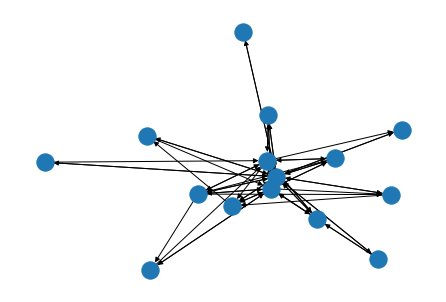

In [62]:
top ='asyn120to140.lig41.pdb'
traj ='test.dcd'
desc = {'hydrophobicContacts': 6.0,'hbondContacts': 4.0,'chargedContacts':6.0,'aromaticStacking': 6.0}
state = ['hydrophobicContacts','hbondContacts','chargedContacts','aromaticStacking']

nLigandChains = 1
nProteinChains = 1

tn = TransitionNetworks(top=top, traj=traj, desc=desc,
                        nLigandChains=nLigandChains,nProteinChains=nProteinChains,state=state,
                        h5File='all.hdf5')

tn.generateNetwork(minPopulation=0.0, minTransition=0.0, gexfName="all.gexf")

In [63]:
corr = tn.correlationCoefficients()

In [64]:
corr

{'hydrophobicContacts6.0+hydrophobicContacts6.0': nan,
 'hydrophobicContacts6.0+hbondContacts4.0': nan,
 'hydrophobicContacts6.0+chargedContacts6.0': nan,
 'hydrophobicContacts6.0+aromaticStacking6.0': nan,
 'hbondContacts4.0+hbondContacts4.0': 1.0,
 'hbondContacts4.0+chargedContacts6.0': nan,
 'hbondContacts4.0+aromaticStacking6.0': 0.1478936755661047,
 'chargedContacts6.0+chargedContacts6.0': nan,
 'chargedContacts6.0+aromaticStacking6.0': nan,
 'aromaticStacking6.0+aromaticStacking6.0': 1.0}

In [60]:
with h5.File('all.hdf5', 'r') as f:
    #print(list(f))
    #print(list(f['hydrophobicContacts4.0']['1009']))
    for frame,frame, frame in zip(f['hydrophobicContacts6.0'],f['hbondContacts4.0'],f['aromaticStacking6.0']):
        if 0 not in f['hydrophobicContacts6.0'][frame] or 0 not in f['hbondContacts4.0'][frame]:
            print(frame, list(f['hydrophobicContacts6.0'][frame]), list(f['hbondContacts4.0'][frame]), list(f['aromaticStacking6.0'][frame]))

1004 [0] [2] [0]
1006 [0] [2] [0]
102 [0] [4] [0]
1028 [0] [1] [0]
1034 [0] [1] [1]
1041 [0] [2] [1]
1056 [0] [1] [0]
1059 [0] [1] [0]
1061 [0] [3] [1]
1063 [0] [1] [0]
1070 [0] [1] [0]
1074 [0] [3] [0]
1080 [0] [1] [0]
1088 [0] [1] [0]
1097 [0] [1] [0]
1101 [0] [2] [1]
1109 [0] [3] [0]
120 [0] [1] [0]
123 [0] [3] [0]
130 [0] [1] [0]
134 [0] [1] [0]
141 [0] [3] [0]
144 [0] [1] [1]
16 [0] [3] [1]
17 [0] [1] [0]
186 [0] [2] [0]
197 [0] [2] [2]
199 [0] [2] [0]
20 [0] [2] [2]
202 [0] [1] [1]
203 [0] [1] [2]
205 [0] [1] [1]
207 [0] [2] [1]
21 [0] [3] [0]
211 [0] [2] [2]
220 [0] [1] [1]
222 [0] [2] [0]
229 [0] [3] [1]
235 [0] [1] [0]
252 [0] [1] [0]
253 [0] [4] [0]
259 [0] [1] [0]
26 [0] [3] [0]
270 [0] [1] [1]
288 [0] [2] [1]
291 [0] [1] [0]
296 [0] [1] [1]
301 [0] [2] [0]
305 [0] [2] [0]
308 [0] [2] [0]
337 [0] [1] [0]
339 [0] [1] [0]
34 [0] [1] [0]
344 [0] [1] [0]
365 [0] [1] [1]
369 [0] [3] [0]
378 [0] [1] [0]
380 [0] [1] [0]
382 [0] [4] [1]
391 [0] [2] [0]
393 [0] [1] [1]
41 [0] [2] [0]

In [ ]:
#tn._intermolecularContactPairs()

In [ ]:
#tn._aromaticStacking()

In [ ]:
#tn._hydrophobicContacts()

In [ ]:
#tn._chargedContacts()

In [ ]:
#tn._hbondContacts()

In [ ]:
#tn._polarContacts()

In [ ]:
#with h5.File('test.hdf5', 'r') as f:
#    for frame in range(1000):
#        if f['hbondContacts3.5'][str(frame)][0] != 0:
#            print(frame, f['hbondContacts3.5'][str(frame)][0])

In [ ]:
#tn.generateNetwork(minPopulation=0.01, minTransition=0.01)

In [ ]:
#aromatics = {'TYR': ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']}
#
#proteinAromaticCindex = []
#tyr = []
#ctyr = 0
#for atom in tn.universe.atoms:
#    if atom.resname == 'TYR':
#        if atom.name in aromatics['TYR']:
#            if ctyr < 5:
#                tyr.append(atom.index)
#                ctyr +=1
#            else:
#                tyr.append(atom.index)
#                proteinAromaticCindex.append(tyr)
#                tyr = []
#               ctyr = 0

In [ ]:
#ligandAromaticC = tn.universe.atoms[304:314]
#ligandAromaticC.center_of_mass()

In [ ]:
#ligandAromaticC.guess_bonds()
#print(ligandAromaticC.bonds)

In [ ]:
#ligand = tn.universe.atoms[nAtomsPerProteinChain:]
#ligand.guess_bonds()
#
#elements = [atom.type for atom in ligand]
#
#pos = 0
#neg = 0
#for residue in tn.universe.residues:
#    if residue.resname == 'LIG':
#        for atom in residue.atoms:
#            element = atom.type
#            atomIdx = atom.index
#            
#            if (element == 'N'):
#                bondingDegree = 0
#                for bond in ligand.bonds:
#                    if (atomIdx in ligand.indices):
#                        bondingDegree += 1
#                
#                if (bondingDegree == 4):
#                    pos += 1
#            
#            elif (element == 'O'):  
#                bondingDegree = 0
#                for bond in ligand.bonds:
#                    if (atomIdx in ligand.indices):
#                        bondingDegree += 1
#                        
#                if (bondingDegree == 1):
#                    neg -= 1
#
#charge = pos + neg
#print('Charge of ligand: ', charge)